# Train a JointVAE model

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import numpy as np
import torch

use_cuda = torch.cuda.is_available()
use_cuda

True

In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # change to your device

#### Prepare data list

In [8]:
!ls data

dress_dresslen_train_test_splits.json	loadable_women_primary_dress.csv
dress_sleevelen_train_test_splits.json	rayimages.ipynb
dress_sleeve_train_test_splits.json


#### dress sleeve data

In [9]:
import json
with open("./data/dress_sleeve_train_test_splits.json", "r") as infile:
    data_dict = json.load(infile)
    
data_dict.keys()

dict_keys(['X_train_1', 'y_train_1', 'X_test_1', 'y_test_1', 'X_train_2', 'y_train_2', 'X_test_2', 'y_test_2', 'X_train_3', 'y_train_3', 'X_test_3', 'y_test_3', 'X_train_4', 'y_train_4', 'X_test_4', 'y_test_4', 'X_train_5', 'y_train_5', 'X_test_5', 'y_test_5', 'X_train_6', 'y_train_6', 'X_test_6', 'y_test_6', 'X_train_7', 'y_train_7', 'X_test_7', 'y_test_7', 'X_train_8', 'y_train_8', 'X_test_8', 'y_test_8', 'X_train_9', 'y_train_9', 'X_test_9', 'y_test_9', 'X_train_10', 'y_train_10', 'X_test_10', 'y_test_10'])

In [10]:
image_paths_train = []
image_paths_test = []

root_data_dir = "/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables"

for key, val in data_dict.items():
    if 'X_train' in key:
        image_paths_train.extend([root_data_dir + imgpath for imgpath in val])
    elif 'X_test' in key:
        image_paths_test.extend([root_data_dir + imgpath for imgpath in val])

print(f"Number of train image paths: {len(image_paths_train):,d}")
print(f"Number of test image paths: {len(image_paths_test):,d}")
print()
print("Sample paths:")
print(image_paths_train[0])
print(image_paths_train[-1])
print(image_paths_test[0])
print(image_paths_test[-1])

Number of train image paths: 207,603
Number of test image paths: 23,067

Sample paths:
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/8/2893552_3773662.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/7/2713940_3640098.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/2/8/2856150_3749586.jpg
/home/jovyan/vmldata/raw_source_data/v20180810_all_wearables/3/0/3058817_8191784.jpg


#### loadable dresses data

### Create data loaders

In [11]:
from torchvision import transforms
from utils.dataloader_tools import get_imagelist_dataloader, ImageListDataset

BATCH_SIZE = 128

composed = transforms.Compose([transforms.CenterCrop((256,256)),transforms.Resize((256,256)),transforms.ToTensor()])

# convert rgb is for the cv2 loaded images that I've got in this dir
train_dataset = ImageListDataset(image_paths_train, cut_from='top', cut_amount=256, transform=composed, 
                                 convert_rgb=False, error_handling=True)
test_dataset = ImageListDataset(image_paths_test, cut_from='top', cut_amount=256, transform=composed, 
                                convert_rgb=False, error_handling=True)

train_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=train_dataset)
test_loader = get_imagelist_dataloader(batch_size=BATCH_SIZE, dataset_object=test_dataset)

### Define latent distribution of the model

In [12]:
# Latent distribution will be joint distribution of 10 gaussian normal distributions
# and one 10 dimensional Gumbel Softmax distribution
latent_spec = {'cont': 20, 'disc': [10, 10, 10]}

### Build a model

In [14]:
from jointvae.models_256_convjump2bn import VAE

model = VAE(latent_spec=latent_spec, hidden_dim=512, img_size=(3, 256, 256), use_cuda=use_cuda)

In [15]:
#print(model)

### Train the model

In [16]:
from torch import optim

# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, amsgrad=True) # added amsgrad # orig lr 5e-4

In [17]:
from jointvae.training import Trainer
#from jointvae.training_debug import Trainer

# Define the capacities
# Continuous channels
cont_capacity = [0.0, 6, 25000, 36.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 6, 25000, 36.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0

# Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,
                  disc_capacity=disc_capacity,
                 use_cuda=use_cuda)

#### Initialize visualizer

In [18]:
#from viz.visualize import Visualizer
from viz.visualize import Visualizer

viz = Visualizer(model)
viz.save_images = False # needed to add this so it returns a tensor

In [ ]:
# Note this should be at least 100 epochs for proper training or more but can be less to demo

trainer.train(train_loader, epochs=68, save_training_gif=None)

0/207603	Loss: 45197.387
6400/207603	Loss: 43057.530
12800/207603	Loss: 32160.041
19200/207603	Loss: 26808.888
25600/207603	Loss: 22539.671
32000/207603	Loss: 18665.331
38400/207603	Loss: 17589.172
44800/207603	Loss: 17300.120
51200/207603	Loss: 16998.866
57600/207603	Loss: 16803.618
64000/207603	Loss: 16711.055
70400/207603	Loss: 16630.575
76800/207603	Loss: 16494.922
83200/207603	Loss: 16545.753
89600/207603	Loss: 16383.924
96000/207603	Loss: 16296.319
102400/207603	Loss: 16247.549
108800/207603	Loss: 16180.169
115200/207603	Loss: 16254.331
121600/207603	Loss: 16139.699
128000/207603	Loss: 16152.145
134400/207603	Loss: 15926.967
140800/207603	Loss: 15994.241
147200/207603	Loss: 15983.033
153600/207603	Loss: 15997.012
160000/207603	Loss: 15948.931
166400/207603	Loss: 16010.849
172800/207603	Loss: 15911.628
179200/207603	Loss: 15909.039
185600/207603	Loss: 15984.490
192000/207603	Loss: 15741.497
198400/207603	Loss: 15771.574
204800/207603	Loss: 15785.319
Epoch: 1 Average loss: 18203.69

51200/207603	Loss: 14859.957
57600/207603	Loss: 14859.002
64000/207603	Loss: 14832.520
70400/207603	Loss: 14847.982
76800/207603	Loss: 14865.501
83200/207603	Loss: 14866.441
89600/207603	Loss: 14850.268
96000/207603	Loss: 14904.170
102400/207603	Loss: 14825.392
108800/207603	Loss: 14809.189
115200/207603	Loss: 14820.533
121600/207603	Loss: 14817.303
128000/207603	Loss: 14714.156
134400/207603	Loss: 14799.925
140800/207603	Loss: 14729.967
147200/207603	Loss: 14824.216
153600/207603	Loss: 14864.994
160000/207603	Loss: 14865.154
166400/207603	Loss: 14873.135
172800/207603	Loss: 14838.492
179200/207603	Loss: 14824.087
185600/207603	Loss: 14765.870
192000/207603	Loss: 14762.681
198400/207603	Loss: 14757.890
204800/207603	Loss: 14798.939
Epoch: 9 Average loss: 14828.83
0/207603	Loss: 15183.146
6400/207603	Loss: 14836.709
12800/207603	Loss: 14861.660
19200/207603	Loss: 14882.584
25600/207603	Loss: 14836.570
32000/207603	Loss: 14728.736
38400/207603	Loss: 14859.909
44800/207603	Loss: 14846.331

96000/207603	Loss: 14467.440
102400/207603	Loss: 14510.698
108800/207603	Loss: 14533.297
115200/207603	Loss: 14493.212
121600/207603	Loss: 14648.884
128000/207603	Loss: 14544.169
134400/207603	Loss: 14625.845
140800/207603	Loss: 14555.739
147200/207603	Loss: 14516.435
153600/207603	Loss: 14536.155
160000/207603	Loss: 14569.786
166400/207603	Loss: 14491.980
172800/207603	Loss: 14554.893
179200/207603	Loss: 14557.877
185600/207603	Loss: 14622.720
192000/207603	Loss: 14507.056
198400/207603	Loss: 14553.922
204800/207603	Loss: 14557.585
Epoch: 17 Average loss: 14553.34
0/207603	Loss: 14743.458
6400/207603	Loss: 14498.539
12800/207603	Loss: 14432.044
19200/207603	Loss: 14561.657
25600/207603	Loss: 14570.840
32000/207603	Loss: 14504.981
38400/207603	Loss: 14578.130
44800/207603	Loss: 14626.801
51200/207603	Loss: 14522.109
57600/207603	Loss: 14501.386
64000/207603	Loss: 14525.265
70400/207603	Loss: 14485.144


In [ ]:
print('Done Training')

In [ ]:
print("Testing system")

In [ ]:
save_image_path = "sample_images/305/256"
model_name = "cj2_e68_b128_c20d10-10-10_cmax6_gam36"

### Visualize

In [ ]:
# Plot reconstructions
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get a batch of data
for batch, labels in test_loader:
    break

# Reconstruct data using Joint-VAE model
recon = viz.reconstructions(batch)

plt.figure(figsize=(26,26))
plt.imshow(np.rot90(np.transpose(recon.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_reconstructions.png",dpi=200)

In [ ]:
# Plot samples
samples = viz.samples()

plt.figure(figsize=(26,26))
plt.imshow(np.rot90(np.transpose(samples.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_samples.png",dpi=200)

### Note on Traversals

### Traverses all latent dimensions one by one and plots a grid of images where each row corresponds to a latent traversal of one latent dimension
* size: Number of samples for each latent traversal.

In [76]:
print(viz.model.latent_cont_dim, viz.model.num_disc_latents)

20 3


In [ ]:
# Plot all traversals
traversals = viz.all_latent_traversals(size=20)

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_all_traversals_n20.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals2100.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=1, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(traversals.numpy()[0, :, :]);
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals1100.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=9, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals9100.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=1, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals2101.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=0, disc_idx=0, disc_axis=1, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals2001.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=3, cont_axis=0, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals3000.png",dpi=200)

In [ ]:
# Plot a grid of some traversals
traversals = viz.latent_traversal_grid(cont_idx=12, cont_axis=0, disc_idx=0, disc_axis=0, size=(10, 10))

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
plt.savefig(save_image_path + model_name + "_traversals3000.png",dpi=200)

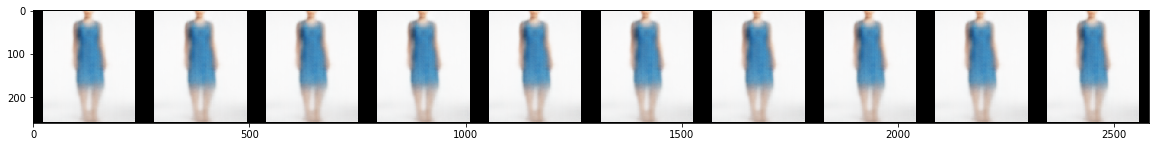

In [93]:
# Plot a grid of some traversals
traversals = viz2.latent_traversal_grid2(cont_idx=3, cont_axis=0, disc_idx=0, disc_axis=0, size=(20, 20),first_n=10)

plt.figure(figsize=(20,20))
plt.imshow(np.rot90(np.transpose(traversals.numpy(),(2,1,0)),k=3));
#plt.savefig("sample_images/306/256/cj1_256_e50maybe_b64_c10d10-10-10_gam30_traversals3000.png",dpi=200)

In [ ]:
!ls

### Save Model

In [ ]:
torch.save(model.state_dict(),"trained_models/" + "statedict_" + model_name) # save state dict
#torch.save(model, model_name) # save full model

In [ ]:
print("Done training: ",model_name)

#### Restore Model from State Dict

In [ ]:
sd_model = VAE(latent_spec=latent_spec, img_size=(3, 64, 64))
sd_model.load_state_dict(torch.load("statedict_" + model_name))

#### Restore Full Model
* Note in this case the serialized data is bound to the specific classes and exact directory strucutre used.

In [ ]:
full_model = torch.load(model_name)

In [ ]:
type(full_model)

In [ ]:
type(sd_model)

In [ ]:
!ls